In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
BATCH_SIZE = 16
SCALE = 1

# todo: normalize data so sigmoid outputs are more varied in decoder final layer

transf = transforms.Compose([transforms.ToTensor(), transforms.Pad([2])])
training_data = datasets.MNIST("./data", train=True, download=True, transform=transf)#

testing_data = datasets.MNIST("./data", train=True, download=True, transform=transf)

train_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(testing_data, batch_size=BATCH_SIZE)

In [ ]:
class VAE(nn.Module):
  def __init__(self, channels, input_dim, latent_dim, beta, gamma):
    super().__init__()

    self.latent_dim = latent_dim

    self.beta = beta
    self.gamma = gamma

    channels_enc = channels

    self.encoder = nn.Sequential()
    self.channels = channels
    self.layers = len(channels)
    self.linear_dim = input_dim**2
    #self.linear_dim = int((32/2**self.layers)**2*channels[-1])

    for i in range(self.layers):
      self.encoder.append(nn.Conv2d(1 if i == 0 else channels_enc[i-1], channels_enc[i], kernel_size=3, stride=2, padding=1))
      self.encoder.append(nn.BatchNorm2d(channels_enc[i]))
      self.encoder.append(nn.ReLU())

    self.decoder = nn.Sequential()

    self.linear = nn.Linear(latent_dim, self.linear_dim)

    channels_dec = channels[::-1]

    for i in range(self.layers):
      self.decoder.append(nn.ConvTranspose2d(channels_dec[i] if i == 0 else channels_dec[i-1], channels_dec[i], kernel_size=3, stride=2, padding=1, output_padding=1))
      self.decoder.append(nn.BatchNorm2d(channels_dec[i]))
      self.decoder.append(nn.ReLU())

    self.decoder.append(nn.Conv2d(channels[0], 1, kernel_size=3, stride=1, padding=1))
    self.decoder.append(nn.Sigmoid())

    self.mu = nn.Linear(self.linear_dim, latent_dim)
    self.log_var = nn.Linear(self.linear_dim, latent_dim)
    self.double()

  def encode(self, x):
    encoded = self.encoder(x)
    encoded = torch.flatten(encoded, 1)
    mu = self.mu(encoded)
    log_var = self.log_var(encoded)

    return [mu, log_var]

  def decode(self, x):
    x = self.linear(x)
    x = x.reshape(-1, self.channels[-1], 1, 1) # todo: come up with expression so number (eg4) does not have to be hardcoded
    decoded = self.decoder(x)
    return decoded

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + std * eps

  def forward(self, x):
    mu, log_var = self.encode(x)
    z = self.reparameterize(mu, log_var)

    return [x, z, self.decode(z), mu, log_var]

  def calc_loss(self, input, reconstructed, mu, log_var, train):
    recons_loss = F.mse_loss(reconstructed, input, reduction="sum")
    #recons_loss = F.binary_cross_entropy(reconstructed, input, reduction="sum")

    kld_loss = -0.5 * torch.sum(1 + log_var - mu**2 - torch.log(log_var))

    # todo: add beta parameter using the "correct" physical model

    loss = recons_loss
    if train:
      loss = self.beta * loss
      loss = loss + kld_loss #self.beta * kld_loss
    else:
      loss = loss + kld_loss
    # loss = recons_loss + self.gamma * (kld_loss - C).abs()
      #print("{}, {}, {}".format(recons_loss.data, kld_loss.data, loss.data))
    return [loss, recons_loss]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class AE(nn.Module):
  def __init__(self, channels, input_dim, latent_dim, beta, gamma):
    super().__init__()

    self.latent_dim = latent_dim

    self.beta = beta
    self.gamma = gamma

    channels_enc = channels

    self.encoder = nn.Sequential()
    self.channels = channels
    self.layers = len(channels)
    self.linear_dim = input_dim**2
    #self.linear_dim = int((32/2**self.layers)**2*channels[-1])

    for i in range(self.layers):
      self.encoder.append(nn.Conv2d(1 if i == 0 else channels_enc[i-1], channels_enc[i], kernel_size=3, stride=2, padding=1))
      self.encoder.append(nn.BatchNorm2d(channels_enc[i]))
      self.encoder.append(nn.ReLU())


    self.linear_enc = nn.Linear(self.linear_dim, latent_dim)

    self.decoder = nn.Sequential()

    self.linear = nn.Linear(latent_dim, self.linear_dim)

    channels_dec = channels[::-1]

    for i in range(self.layers):
      self.decoder.append(nn.ConvTranspose2d(channels_dec[i] if i == 0 else channels_dec[i-1], channels_dec[i], kernel_size=3, stride=2, padding=1, output_padding=1))
      self.decoder.append(nn.BatchNorm2d(channels_dec[i]))
      self.decoder.append(nn.ReLU())

    self.decoder.append(nn.Conv2d(channels[0], 1, kernel_size=3, stride=1, padding=1))
    self.decoder.append(nn.Sigmoid())


    self.double()

  def encode(self, x):
    encoded = self.encoder(x)
    encoded = torch.flatten(encoded, 1)
    encoded = self.linear_enc(encoded)

    return encoded

  def decode(self, x):
    x = self.linear(x)
    x = x.reshape(-1, self.channels[-1], 1, 1) # todo: come up with expression so number (eg4) does not have to be hardcoded
    decoded = self.decoder(x)
    return decoded


  def forward(self, x):
    encoded = self.encode(x)

    return [x, encoded, self.decode(encoded), -1, -1]

  def calc_loss(self, input, reconstructed, mu, log_var, train):
    recons_loss = F.mse_loss(reconstructed, input, reduction="sum")
    #recons_loss = F.binary_cross_entropy(reconstructed, input, reduction="sum")

    # todo: add beta parameter using the "correct" physical model
    return [recons_loss, recons_loss]

In [ ]:
CHANNELS = [32, 64, 128, 256]
LATENT_DIM = 10
BETA = 0.5
GAMMA = -1
LEARNING_RATE = 0.001
INPUT_DIM = 16

In [ ]:
def train(model):
  train_loss = 0
  last_loss = 0

  model.train()

  for idx, (data) in enumerate(train_loader):
    data = data.view(-1, 1, INPUT_DIM, INPUT_DIM)
    data = data.to(device)
    input, encoded, output, mu, log_var = model(data)
    loss, recons_loss = model.calc_loss(input, output, mu, log_var, True)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    # if idx % 1000 == 999:
    #   last_loss = train_loss / 1000
    #   print("Batch {} loss: {}".format(idx+1, last_loss))
    #   train_loss = 0


  return train_loss

In [ ]:
def test(model):
  test_loss = 0
  test_rloss = 0

  model.eval()

  with torch.no_grad():
    for idx, (data) in enumerate(test_loader):
      data = data.view(-1, 1, INPUT_DIM, INPUT_DIM)
      data = data.to(device)
      input, encoded, output, mu, log_var = model(data)
      loss, recons_loss = model.calc_loss(input, output, mu, log_var, False)
      test_loss += loss.item()
      test_rloss += recons_loss.item()

  return [test_loss, test_rloss]


In [ ]:
def train_model(model):
  epochs = 20
  best_loss = 10000000
  best_rloss = 10000000

  for i in range(epochs):
    train_loss = train(model)
    test_loss, test_rloss = test(model)

    train_loss /= len(training_data)
    test_loss /= len(testing_data)
    test_rloss /= len(testing_data)

    if test_loss < best_loss or test_rloss < best_rloss:
      best_loss = min(test_loss, best_loss)
      best_rloss = min(test_rloss, best_rloss)
      # Naming format: model_{latent_dim}_{beta}_{index}_{mse+kld}_{mse}
      model_path = "model_{}_{}_{}_{}_{}".format(model.latent_dim, model.beta, i, f'{test_loss:.4f}', f'{test_rloss:.4f}')
      torch.save(model.state_dict(), model_path)

    print("Epoch {}, Train Loss: {}, Test Loss: {}, Test Loss (no KLD): {}".format(i, train_loss, test_loss, test_rloss))

In [ ]:
modelAE = AE(CHANNELS, INPUT_DIM, LATENT_DIM, -1, -1).to(device)
optimizer = optim.Adam(modelAE.parameters(), lr=LEARNING_RATE)

train_model(modelAE)

Epoch 0, Train Loss: 0.195675938948891, Test Loss: 0.19781815055974625, Test Loss (no KLD): 0.19781815055974625
Epoch 1, Train Loss: 0.1284545922414663, Test Loss: 0.2083796100313978, Test Loss (no KLD): 0.2083796100313978
Epoch 2, Train Loss: 0.11161368467112773, Test Loss: 0.19417733811956928, Test Loss (no KLD): 0.19417733811956928
Epoch 3, Train Loss: 0.10079311885258253, Test Loss: 0.26350578725738244, Test Loss (no KLD): 0.26350578725738244
Epoch 4, Train Loss: 0.09436978730126927, Test Loss: 0.1566648342829906, Test Loss (no KLD): 0.1566648342829906
Epoch 5, Train Loss: 0.08968980570416793, Test Loss: 0.14024071834845306, Test Loss (no KLD): 0.14024071834845306
Epoch 6, Train Loss: 0.08555743547351043, Test Loss: 0.15826167473775068, Test Loss (no KLD): 0.15826167473775068
Epoch 7, Train Loss: 0.08471951095342993, Test Loss: 0.1394026896878832, Test Loss (no KLD): 0.1394026896878832
Epoch 8, Train Loss: 0.0812204022652221, Test Loss: 0.12805312120611712, Test Loss (no KLD): 0.12

In [ ]:
modelVAE = VAE(CHANNELS, INPUT_DIM, 10, BETA, -1).to(device)
optimizer = optim.Adam(modelVAE.parameters(), lr=LEARNING_RATE)

train_model(modelVAE)

Epoch 0, Train Loss: nan, Test Loss: nan, Test Loss (no KLD): 2.7112543115084495
Epoch 1, Train Loss: nan, Test Loss: nan, Test Loss (no KLD): nan
Epoch 2, Train Loss: nan, Test Loss: nan, Test Loss (no KLD): nan
Epoch 3, Train Loss: nan, Test Loss: nan, Test Loss (no KLD): nan
Epoch 4, Train Loss: nan, Test Loss: nan, Test Loss (no KLD): nan
Epoch 5, Train Loss: nan, Test Loss: nan, Test Loss (no KLD): nan
Epoch 6, Train Loss: nan, Test Loss: nan, Test Loss (no KLD): nan
Epoch 7, Train Loss: nan, Test Loss: nan, Test Loss (no KLD): nan
Epoch 8, Train Loss: nan, Test Loss: nan, Test Loss (no KLD): nan
Epoch 9, Train Loss: nan, Test Loss: nan, Test Loss (no KLD): nan


KeyboardInterrupt: 

In [ ]:
#model_path = "drive/MyDrive/Synopsys/Models/model_10_1_7_0.0095_0.0095"
model_path = "drive/MyDrive/Synopsys/Models/model_10_-1_18_0.1240_0.1240"
#model_path = "drive/MyDrive/Synopsys/Models/model_10_2_7_0.3246_0.3246"

loaded_model = AE(CHANNELS, INPUT_DIM, 10, 1, GAMMA).to(device)
loaded_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
loaded_model.eval()

loaded_model

AE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (linear_enc): Linear(in_features=256, out_features=10, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, mo

In [ ]:
beta = 1.5
dim = 5
while beta <= 2:
  while dim <= 20:
    if not(beta == 1.5 and dim == 5):
      model = VAE(CHANNELS, dim, beta, -1).to(device)
      optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
      train_model(model)

    dim += 5
  dim = 5
  beta += 0.5

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

pca = PCA(n_components=2)

encoded = [] # (36,000 x 10)
labels = []

for i in range(len(training_data)):
  x = training_data.__getitem__(i).view(-1, 1, INPUT_DIM, INPUT_DIM).to(device)
  (_, z, _, _, _) = loaded_model(x)
  z = z.detach().cpu()[0]
  encoded.append(z.numpy())


In [ ]:
mean = np.mean(encoded, axis=0)
std = np.std(encoded, axis=0)

encoded = (encoded - mean) / std
reduction = pca.fit_transform(encoded) # (36,000 x 2)

In [ ]:
index = 31

test_point = training_data.__getitem__(index).view(-1, 1, INPUT_DIM, INPUT_DIM).to(device)
(_, z, _, _, _) = loaded_model(test_point)
z = z.cpu().detach().numpy()
z = (z - mean) / std

print(z)
r = pca.transform(z)

[[-1.13631867 -0.10594072  0.4136077  -1.44025813 -1.43060981  0.06649755
  -0.44626793  2.05342343 -0.39808382 -2.36318189]]


In [ ]:
print(r[0])
print(reduction[31])

[0.85113715 0.90332707]
[0.85113715 0.90332707]


In [ ]:
outliers = []
for i in range(len(reduction)):
  if (np.abs(reduction[i][0]) > 0.7 or np.abs(reduction[i][1]) > 1.7):
    outliers.append(i)

In [ ]:
def plot_latent(data, labels, num_batches):
  plt.scatter(data[:, 0][: num_batches], data[:, 1][: num_batches], c='blue')
  for i in range(len(outliers)):
    if outliers[i] > num_batches:
      break
    plt.scatter(data[outliers[i]][0], data[outliers[i]][1], c='red')

  #plt.scatter(r[0][0], r[0][1], c='green')
  #plt.colorbar()

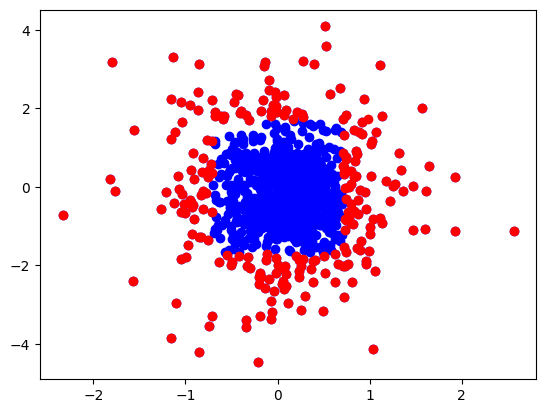

In [ ]:
plot_latent(reduction, labels, 1000)

In [ ]:
print(outliers)

[0, 5, 7, 10, 25, 26, 27, 28, 29, 31, 44, 51, 52, 59, 60, 67, 71, 78, 87, 89, 92, 98, 99, 113, 125, 133, 134, 135, 138, 139, 140, 145, 146, 149, 150, 151, 156, 159, 160, 164, 168, 170, 171, 173, 176, 179, 180, 188, 189, 195, 204, 211, 212, 221, 230, 236, 238, 241, 242, 249, 262, 263, 267, 270, 272, 276, 297, 298, 301, 305, 307, 314, 316, 317, 330, 332, 339, 340, 350, 355, 364, 376, 381, 390, 391, 399, 401, 409, 414, 415, 416, 417, 420, 423, 425, 434, 435, 437, 440, 443, 446, 448, 456, 457, 458, 459, 460, 464, 468, 469, 471, 472, 481, 488, 490, 493, 495, 501, 504, 517, 518, 526, 531, 535, 538, 557, 559, 561, 566, 567, 571, 573, 574, 577, 579, 582, 587, 589, 593, 594, 596, 598, 599, 603, 605, 607, 610, 612, 616, 621, 627, 635, 638, 646, 654, 664, 667, 670, 672, 675, 683, 686, 691, 692, 697, 698, 699, 708, 709, 714, 721, 727, 737, 738, 743, 747, 758, 761, 763, 766, 769, 775, 778, 786, 787, 795, 805, 808, 813, 821, 836, 845, 846, 852, 853, 858, 871, 872, 873, 876, 877, 880, 885, 890, 893, 

In [ ]:
#test_item = random.randint(0, 36000)
test_item = 31
item = training_data.__getitem__(test_item)[0].view(-1, 1, INPUT_DIM, INPUT_DIM).to(device)

print(test_item)
print(training_data.details[test_item])

(_, _, result, _, _) = modelVAE(item)

print(item.detach().cpu().data[0][0].view(INPUT_DIM, INPUT_DIM)[0][0])
print(item.detach().cpu().data[0][0].view(INPUT_DIM**2, -1)[0])

f, axarr = plt.subplots(4,1, figsize=(10, 10))
axarr[0].set_ylim([0, 1])
axarr[1].set_ylim([0, 1])
axarr[0].plot(training_data.times[0], item.detach().cpu().data[0][0].view(INPUT_DIM**2, -1), color="black")
axarr[1].plot(training_data.times[0], result.detach().cpu().data[0][0].view(INPUT_DIM**2, -1), color="black")
axarr[2].imshow(item.detach().cpu().data[0][0].view(INPUT_DIM, INPUT_DIM), cmap="gray")
axarr[3].imshow(result.detach().cpu().data[0][0], cmap="gray")

31
(0, 7936.0, 31.0)


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

In [ ]:
print(pca.explained_variance_ratio_)

[0.37716554 0.12836172]


In [ ]:
transf_ltc = transforms.Compose([transforms.ToTensor()]) # transforms.Pad([2])

training_data_ltc = EEGDataset(training_files, 0, 5, 1, transf_ltc, 1)

testing_data_ltc = EEGDataset(testing_files, 0, 5, 1, transf_ltc, 1)

In [ ]:
N = SEGMENT_LEN * 256
SAMPLES = 50

data_x = np.array(training_data_ltc.data[0:SAMPLES])
data_x = np.transpose(data_x, (1, 2, 0))
data_y = np.array(training_data_ltc.data[0:5])
data_y = np.transpose(data_y, (1, 2, 0))

print(data_x.shape)
print(data_y.shape)

(1, 1280, 50)
(1, 1280, 5)


In [ ]:
def remove_artifacts(data, item_num):
  data_transf = np.copy(data)
  for idx in range(item_num):
    mean = np.mean(data_transf[0,:,idx])
    upper = np.mean(data_transf[0,:,idx]) + np.std(data_transf[0,:,idx])
    lower = np.mean(data_transf[0,:,idx]) - np.std(data_transf[0,:,idx])

    for i in range(len(data_transf[0,:,idx])):
      if (i/256) in outliers or (i/256)+1 in outliers:
        for i in range(int(i/256*256), int(((i/256)+1)*256)):
          if (data_transf[0,:,idx][i] > upper or data_transf[0,:,idx][i] < lower):
            data_transf[0,:,idx][i] = mean

  return data_transf


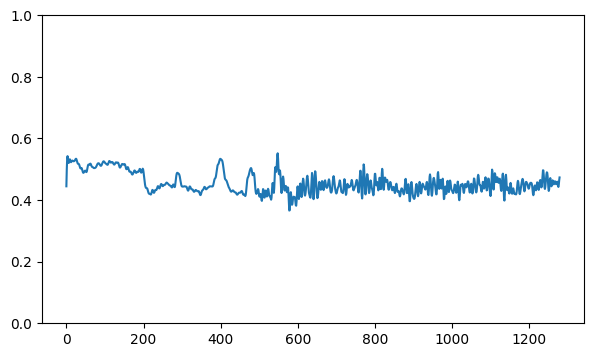

In [ ]:
plt.figure(figsize=(7, 4))
plt.ylim(0, 1)
plt.plot(data_x[0, :, 0])

In [ ]:
data_x = remove_artifacts(data_x, SAMPLES)

In [ ]:
data_y = remove_artifacts(data_y, int(SAMPLES/10))

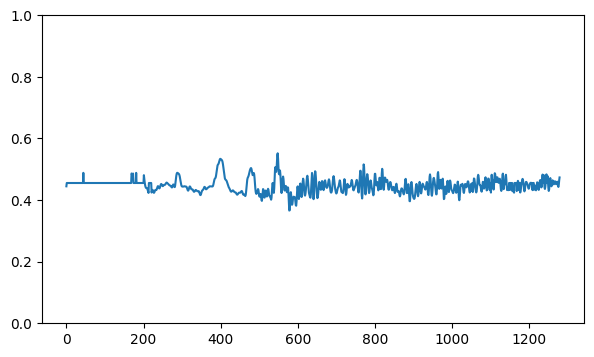

In [ ]:
plt.figure(figsize=(7, 4))
plt.ylim(0, 1)
plt.plot(data_x[0, :, 0])

In [ ]:
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)
data_loader = DataLoader(
    torch.utils.data.TensorDataset(data_x, data_y), batch_size=16, shuffle=True, num_workers=1
)

In [ ]:
class SequenceLearner(pl.LightningModule):
  def __init__(self, model, lr=0.005):
    super().__init__()
    self.model = model
    self.lr = lr

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat, _ = self.model.forward(x)
    y_hat = y_hat.view_as(y)

    result = y_hat.detach().cpu().numpy()[0][0]
    diffs = np.abs(result[1:] - result[:-1])
    diff_mean = np.mean(diffs)

    mse_loss = nn.MSELoss()(y_hat*1000, y*1000)
    slope_loss = (1/diff_mean)/10

    loss = mse_loss
    self.log("train_loss", loss, prog_bar=True)
    return {"loss": loss}

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat, _ = self.model.forward(x)
    y_hat = y_hat.view_as(y)

    result = y_hat.detach().cpu().numpy()[0][0]
    diffs = np.abs(result[1:] - result[:-1])
    diff_mean = np.mean(diffs)

    mse_loss = nn.MSELoss()(y_hat, y)
    slope_loss = (1/diff_mean)/10

    loss = mse_loss
    self.log("val_loss", loss, prog_bar=True)
    return loss

  def test_step(self, batch, batch_idx):
    return self.validation_step(batch, batch_idx)

  def configure_optimizers(self):
    return optim.Adam(self.model.parameters(), lr=self.lr)

In [ ]:
out_features = 5
in_features = 50

wiring = AutoNCP(100, out_features)

ltc_model = LTC(in_features, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=200,
    gradient_clip_val=1,
    log_every_n_steps=1
)

alloc!


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


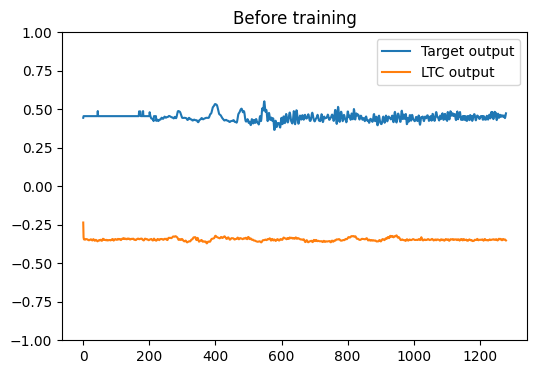

In [ ]:
with torch.no_grad():
  prediction = ltc_model(data_x)[0].numpy()

plt.figure(figsize=(6, 4))
plt.plot(data_x[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="LTC output")
plt.ylim(-1, 1)
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [ ]:
trainer.fit(learn, data_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | LTC  | 75.4 K
-------------------------------
60.4 K    Trainable params
15.0 K    Non-trainable params
75.4 K    Total params
0.302     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


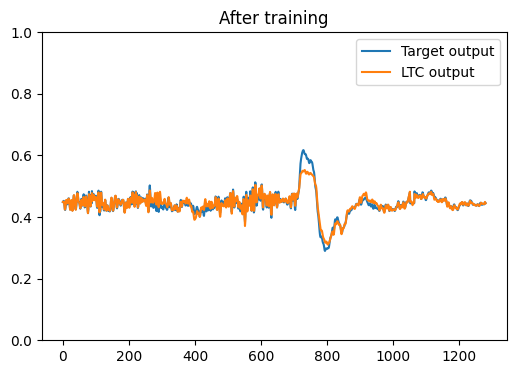

In [ ]:
with torch.no_grad():
  prediction = ltc_model(data_x)[0].numpy()

plt.figure(figsize=(6, 4))
item = 4
plt.plot(data_x[0, :, item], label="Target output")
plt.plot(prediction[0, :, item], label="LTC output")
plt.ylim(0, 1)
plt.title("After training")
plt.legend(loc="upper right")
plt.show()

In [ ]:
seizure_test = []
idx = 0
for i in range(int(len(training_data_ltc.data)/SAMPLES)):
  data_seg = np.array(training_data_ltc.data[idx : idx+SAMPLES])
  data_seg = np.transpose(data_seg, (1, 2, 0))
  data_seg = torch.Tensor(data_seg)
  seizure_test.append(data_seg)
  idx += SAMPLES

In [ ]:
for i in range(len(seizure_test)):
  with torch.no_grad():
    prediction = ltc_model(seizure_test[i])[0].numpy()

  for j in range(len(prediction[0][0])):
    data_seg = seizure_test[i][0, :, j].numpy()
    pred_seg = prediction[0, :, j]
    mean_percent_error = np.mean(abs(pred_seg-data_seg)/data_seg*100)

    # print(mean_percent_error)
    if (mean_percent_error > 50 and mean_percent_error != float('inf')):
      print(mean_percent_error)
      plt.figure(figsize=(6, 4))
      plt.plot(data_seg, label="Item")
      plt.plot(pred_seg, label="LTC output")
      plt.ylim(0, 1)
      plt.title("After training")
      plt.legend(loc="upper right")
      plt.show()
      print("Seizure detected.")

<ipython-input-79-efa73ad6bd47>:8: RuntimeWarning: divide by zero encountered in divide
  mean_percent_error = np.mean(abs(pred_seg-data_seg)/data_seg*100)
